![title](img/skimlit.png)

## 📖 The purpose of SkimLit is to build a NLP model to make reading medical abstracts easier.

The paper being replicated is available [here](https://arxiv.org/abs/1710.06071) <br>
The dataset can be found [here](https://github.com/Franck-Dernoncourt/pubmed-rct.git)

---
### ⬇️ Download the <span style="color:green">data</span>.
Start with the smaller, 20k Dataset. Once a model that performs best with the 20k dataset is found, upscale the model to train on the 200k dataset 

In [5]:
import os

# If file doesn't already exist, download the dataset
if os.path.exists('./data/pubmed-rct'):
    print("File already exists")
else:
    !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

File already exists


In [6]:
# List files inside the PubMed_20k dataset
!ls data/pubmed-rct/pubmed_20k_rct_numbers_replaced_with_at_sign/
!ls data/pubmed-rct/pubmed_20k_rct/

dev.txt   test.txt  train.txt
dev.txt   test.txt  train.txt


In [7]:
# Start with the smaller dataset, with numbers replaced with "@" sign
data_dir = "data/pubmed-rct/pubmed_20k_rct_numbers_replaced_with_at_sign/"

---
<h1 align="center">🤖 Preprocess Data</h3> 

In [4]:
# Create a function that reads the lines of a document
def get_lines(filename):
    """
    Reads filename (a text file) and returns the lines of text as a list.

    Args:
      filename: a string containing the target filepath to read.

    Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
    """
    with open(filename, "r") as f:
        return f.readlines()

In [5]:
# Read the lines of the training dataset, into a variable
train_lines = get_lines(data_dir + "train.txt") 

# Show the first 10 lines
train_lines[:10] 

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
print(f'There are {len(train_lines)} training lines')

There are 210040 training lines


### Dataset Format
Load data into python dictionaries, this adds structure to the dataset that the text file doesn't have

```
[
    {
        'line_number': 0,
        'target': 'BACKGROUND',
        'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
        'total_lines': 11
    },

    # Next instance of data
    {
        ......
    }
]
```
### Define a function to load data into the data structure shown above

In [7]:
def preprocess_text(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
      filename: a string of the target text file to read and extract line data
      from.

    Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """

    input_lines = get_lines(filename)
    abstract_lines = "" # Create
    abstract_samples = []

    for line in input_lines:
        
        if line.startswith("###"): # Check to see if the new line is the ID label
            abstract_id = line
            abstract_lines = "" # Reset the abstract string if the line is the ID

        # A space indicates the start of another abstract, so we have to process the current abstract before moving
        # a new abstract
        elif line.isspace(): # Check if the new line is a space
            
            # Split the abstract into seperate lines
            # the splitlines() function looks for a line break and splits the lines
            abstract_line_split = abstract_lines.splitlines() # Returns a list of strings
        
            # Iterate through each line in the abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                # Populate the dictionary with the line data
                abstract_dict = {}

                # Splits the target text and text
                target_text_split = abstract_line.split('\t')

                # Populate the dictionary
                abstract_dict['target'] = target_text_split[0]
                abstract_dict['text'] = target_text_split[1].lower()
                abstract_dict['line_number'] = abstract_line_number
                abstract_dict['total_lines'] = len(abstract_line_split) - 1 # We want to start from 0

                abstract_samples.append(abstract_dict)

        # If neither of the above two criteria is fulfilled, the line is a target label / text line
        # So just append the data into the abstract_lines string
        else:
            abstract_lines += line
        
    return abstract_samples

### 🖖🏽 Dataset Split

In [8]:
%%time

# Get the data and preprocess it
train_samples = preprocess_text(data_dir + 'train.txt')
val_samples = preprocess_text(data_dir + 'dev.txt') # dev is another name for validation
test_samples = preprocess_text(data_dir + 'test.txt')
print("No. of training samples: {} \nNo. of validation samples: {} \nNo. of testing samples: {}"
        .format(len(train_samples), len(val_samples), len(test_samples))
)

No. of training samples: 180040 
No. of validation samples: 30212 
No. of testing samples: 30135
CPU times: user 428 ms, sys: 47.3 ms, total: 476 ms
Wall time: 475 ms


In [9]:
train_samples[:12] # Check the lines of the first abstract in the training abstract

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
import pandas as pd

# Turn dictionaries into pandas DataFrame to better visualize it
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

# Show first 13 lines of data
train_df.head(13)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


---
<h1 align="center">👨🏽‍💻 Dataset Analysis</h3> 


<AxesSubplot:>

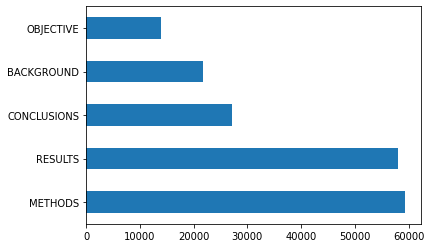

In [11]:
# Visualize the distribution in training data (according to no. of samples per target)

train_df['target'].value_counts().plot(kind='barh')

<AxesSubplot:ylabel='Frequency'>

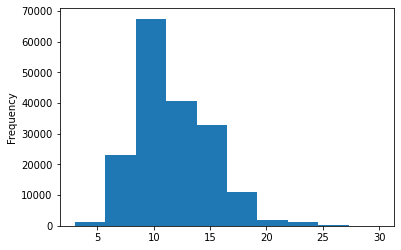

In [12]:
# Let's check the distribution of the length of lines
train_df['total_lines'].plot.hist()

<b>Get list of sentences</b> <br>
The main inputs to the deep learning model, would be a list of strings which we can obtain via the function below

In [13]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences),

(180040, 30212, 30135)

In [14]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

---
<h1 align="center">🛠 Feature Engineering</h3> 


### Encoding
ML models require numeric labels <br>
<br>
<b>Two methods</b>
1. Label Encode (e.g `Methods -- 1, Results -- 2, ...`)
2. One-hot encode (e.g `Methods -- [1,0,0,0,0], Results -- [0,1,0,0,0]`)

> <b>What does `sparse` mean?</b> <br>
A sparse array is one that contains mostly zeros and few non-zero entries

> <b>What does `dense` mean?</b> <br>
A dense array contains mostly non-zeros

### 1️⃣ One-hot encode labels

In [15]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))


In [16]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

2021-08-19 15:02:17.902469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### 2️⃣ Label encode labels

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded # These labels are label encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class (reverse engineer to get the class names)
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments
Trying out different models and seeing which one works best

| Experiment | Model Name |
| --- | --- |
| 0 | TF-IDF Multinomial Naive Bayes Classifier (Baseline) |
| 1 | Conv1D with token embeddings |
| 2 | TensorFlow Hub Pretrained Feature Extractor |
| 3 | Conv1D with character embeddings |
| 4 | Pretrained token embeddings (same as 2) + character embeddings (same as 3) |
| 5 | Pretrained token embeddings + character embeddings + positional embeddings |

---

![title](img/model_0.png)

<b>Naive Bayes Classifier</b>


Bayes Theorem 

$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$

If any two events are independent, then $P(A,B) = P(A)P(B)$

Using the above two concepts, we can reach this result

P(y|X) = $\frac{P(X|y)P(y)}{P(X)}$ where X = (x_1, x_2, ..., x_n)


P(y|x_1,...x_n) = $\frac{P(x_1|y)...P(x_n|y)P(y)}{P(x_1)...P(x_n)}$

y = $argmax_yP(y)\sum_{i=1}^{n}P(x_i|y)$

<b>Term Frequency - Inverse Document Frequency</b>

Generally used to compute how important/relevant a word is to a certain document. It approaches 0 when it is a common word (e.g 'when', 'the', etc) and 1 when it is unique.

# 🏋️‍♀️ Model Training

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [20]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

# ✍🏽 Model Evaluation
### ❌ Cross validation

In [21]:
from sklearn.model_selection import cross_val_predict

# Make predictions using the Naive Bayes Classifier
baseline_preds = model_0.predict(val_sentences)

# Make predictions using the K-fold cross validation
y_val_preds = cross_val_predict(model_0, val_sentences, val_labels_encoded, cv=3)

print(baseline_preds)
print(y_val_preds)

[4 1 3 ... 4 4 1]
[4 1 2 ... 4 4 0]


### 🤔 Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix
'''
An optimal confusion matrix would be one with non-zero integers in the diagonal (top left to bottom right)

1 0 0 0 0
0 1 0 0 0
0 0 1 0 0
0 0 0 1 0
0 0 0 0 1
'''

confusion_matrix(val_labels_encoded, baseline_preds)

array([[1683,  794,  694,   97,  181],
       [ 244, 2687,  432,    5, 1214],
       [ 116,   75, 8670,    7, 1096],
       [ 505,  422,  978,  325,  146],
       [  20,  181, 1196,    1, 8443]])

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculate_results(y_true, y_pred):
    '''
    Calculates model accuracy, precision, recall, f1 score of a binary classification model
    
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
        
    Returns:
        A dictionary of metrics
    '''
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    
    # Calculate the model precision, recall and f1 score
    model_precision = precision_score(y_true, y_pred, average='weighted')
    model_recall = recall_score(y_true, y_pred, average='weighted')
    model_f1 = f1_score(y_true, y_pred, average='weighted')
    
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

### ⚖️ Metrics

In [24]:
# Calculate the baseline results on the validation dataset
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=y_val_preds)

In [25]:
all_model_results = pd.DataFrame({
    "Multinomial Naive Bayes Classifier": baseline_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,f1,precision,recall
Multinomial Naive Bayes Classifier,66.483516,0.618607,0.668206,0.664835


Above are the model results for the <b>baseline model</b>. We aim to beat these results in the upcoming experiments

---
![title](img/model_1.png)

# 👨🏽‍💻 Dataset Analysis


### Prepare data for deep sequence modelling
In order to train our deep neural networks, we need to preprocess our data in a different way. Namely, tokenization and embedding layers. <br> 
The following code is to obtain more information about the `training_sentences` so we can create the tokenization layers with appropriate parameters

<b>✍🏽Average Sentence length<b>

In [26]:
# Import relevant libraries for creating vectorization and embedding layers
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# If we want to create embedding layers, we need the sentences to be of equal lengths
sentence_lengths = [len(sentence.split()) for sentence in train_sentences] # Must use .split() since we only want words
avg_sentence_length = np.mean(sentence_lengths)

avg_sentence_length

26.338269273494777

<b>📊Visualize the distribution of sentence lengths<b>

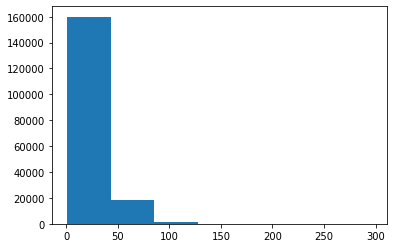

In [28]:
# Visualize the distribution of sentence lengths to get a clearer picture
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=7);

Looks like majority of the sentences are between 0 and 50 tokens in length

In [29]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sentence_lengths, 95))
output_seq_len

55

This means that 95% of the sentences have 55 tokens or less. When creating the tokenization layer, we'll use this value to make all sentences the same length. Sentences with lengths below 55 get padded with zeros and those above get truncated.

In [30]:
# Calculate the maximum length of the sentences
max(sentence_lengths)

296

Since 95% of sentences are below 55 tokens in length, it wouldn't make sense to set 296 as the maximum length because then, majority of the data we pass to our model would be zeros (from padding)

## Convert sentences into numbers
Method 1: <b> Text Vectorizer </b>
<br>
Method 2: <b> Tokenizer</b>

### 1️⃣ Creating a Text vectorizer
Using the information from above, the appropriate value for `max_length` is 55.

In [31]:
# Vocabulary size for the 20k dataset is 68000 according to the paper
max_tokens = 68000
max_length = 55

In [32]:
# Two methods, TextVectorization & Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=max_tokens, # Number of words in vocabulary 
    output_sequence_length = max_length # Desired output of vectorized sentences
)

In [33]:
# Adapt textvectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Testing out the text vectorizer
import random

random_sentence = random.choice(train_sentences)
print(f"Actual Text:\n{random_sentence}\n")
print(f"Length of text: {len(random_sentence.split())}\n")
print(f"Vectorized sentence:\n{text_vectorizer([random_sentence])}")

Actual Text:
similar numbers of subjects in both groups attained an hba@c level of < @ % ( @ vs. @ % ) ; therefore , superiority of glargine over liraglutide was not observed ( p = @ ) .

Length of text: 38

Vectorized sentence:
[[ 150 1516    4  104    5   54   24 5682   26  615  204    4   44  709
  1622    4 2578  145 2654   10   31  148   14    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Re-run the cell to get different sentences. Notice that shorter sentences get padded with more zeros.

### Obtain vocab list
Obtain vocabulary of the dataset, using the `.get_vocabulary()` method of the text vectorizer

In [35]:
rct_20k_vocab = text_vectorizer.get_vocabulary()

# Get the size of the vocabulary
print(f"Number of words in vocabulary: {len(rct_20k_vocab)}\n")
print(f"Most commmon words in vocabulary: {rct_20k_vocab[:5]}\n")
print(f"Least common words in vocabulary: {rct_20k_vocab[-5:]}")

Number of words in vocabulary: 64841

Most commmon words in vocabulary: ['', '[UNK]', 'the', 'and', 'of']

Least common words in vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


Get the configuration of the text vectorizer using the `.get_config()` method

In [36]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'vocabulary_size': 64841}

### Create text embeddings
Earlier, we mapped words to numbers, but this doesn't capture relationships between the numbers. To do this, we can use <b>embeddings</b>

In [37]:
embedding_dim = 128

# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show an instance of embedding
print(f"Sentence before embedding:\n{random_sentence}\n")

vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Shape of embedded sentence: {embedded_sentence.shape}\n")

Sentence before embedding:
similar numbers of subjects in both groups attained an hba@c level of < @ % ( @ vs. @ % ) ; therefore , superiority of glargine over liraglutide was not observed ( p = @ ) .

Sentence after vectorization (before embedding):
[[ 150 1516    4  104    5   54   24 5682   26  615  204    4   44  709
  1622    4 2578  145 2654   10   31  148   14    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.02307271  0.00032489 -0.01866502 ... -0.04965007  0.00624509
   -0.04821149]
  [ 0.04746575  0.04816638 -0.01914396 ...  0.04209292  0.01153727
    0.02278963]
  [ 0.02750507  0.02157098 -0.01720276 ...  0.00573365 -0.04924428
    0.0248138 ]
  ...
  [ 0.0371047  -0.00056776 -0.01253436 ...  0.02301976 -0.01017199
    0.00038773]
  [ 0.0371047  -0.00056776 -0.01253436 ...  0.02301976 -0.01017199
    0.00038773]
  [ 0.0371047  -

### Create datasets (for quick runtime)
The tf.data API provides methods that enable faster data loading <br>
Create a PrefetchDataset of batches from our data that we have prepared. Use the batch() and prefetch() method, and the tf.data.AUTOTUNE (allow tf to determine the optimal amount of compute to prepare datasets)

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [39]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# 🏋️‍♀️ Model Training

The input data to a deep sequence model is different from the one we feeded into a naive bayes model. We need to prepare data in another format
> Input (text) ➡ Tokenizer ➡ Embedding ➡ Layers ➡ Output (label probability)

After building our model
> Build model ➡ Train model ➡ Evaluate model (compare with ground truth and baseline model performance)

In [40]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [42]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
  1/562 [..............................] - ETA: 5:55 - loss: 1.6033 - accuracy: 0.4062

2021-08-19 15:02:57.685739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


562/562 [==============================] - 39s 69ms/step - loss: 0.9094 - accuracy: 0.6427 - val_loss: 0.6809 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 39s 69ms/step - loss: 0.6556 - accuracy: 0.7562 - val_loss: 0.6244 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 41s 73ms/step - loss: 0.6171 - accuracy: 0.7731 - val_loss: 0.5934 - val_accuracy: 0.7889


# ✍🏽 Model Evaluation
### ❌ Cross validation

In [43]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 1s 1ms/step - loss: 0.5965 - accuracy: 0.7867


[0.5964944958686829, 0.7867403626441956]

In [44]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.3293190e-01, 1.7091839e-01, 8.5026823e-02, 2.8295434e-01,
        2.8168542e-02],
       [4.3780074e-01, 2.7970335e-01, 1.5791850e-02, 2.5738573e-01,
        9.3182931e-03],
       [1.3719885e-01, 4.5828419e-03, 1.9495605e-03, 8.5623169e-01,
        3.7095964e-05],
       ...,
       [3.8434709e-06, 5.2270753e-04, 5.5909698e-04, 3.2469800e-06,
        9.9891114e-01],
       [6.0199898e-02, 4.8245928e-01, 8.7729156e-02, 7.7424981e-02,
        2.9218665e-01],
       [1.7380898e-01, 6.9639570e-01, 3.2302186e-02, 4.2371180e-02,
        5.5121932e-02]], dtype=float32)

In [45]:
# Convert these probabilities into classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

### ⚖️ Metrics

In [46]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 78.67403680656693,
 'precision': 0.7833724001477458,
 'recall': 0.7867403680656693,
 'f1': 0.7841796812321693}

In [47]:
all_model_results = pd.DataFrame({
    "Multinomial Naive Bayes Classifier": baseline_results,
    "Conv1D w/ token embeddings": model_1_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
Multinomial Naive Bayes Classifier,66.483516,0.668206,0.664835,0.618607
Conv1D w/ token embeddings,78.674037,0.783372,0.786740,0.784180


---
![title](img/model_2.png) 


Use the pretrained embeddings as a way to initialize token embeddings

The tokenizer layer is _missing_, but the Universal Sentence Encoder will take care of the tokenisation for us.

# 🏋️‍♀️ Model Training

### Use a pretrained embedding layer from TFHub
To download the pretrained USE, and use it in our model, we can use `Hub.KerasLayer`.
Keep the pre-trained embedding layer(by setting the method `trainable=False` and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [48]:
import tensorflow_hub as hub

# the model is relatively large, so it may take a while to load
universal_sentence_encoder = hub.KerasLayer("./universal-sentence-encoder_4",
                                       trainable=False,
                                       name="universal_sentence_encoder")

In [49]:
# Test the layer
random_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_sentence}\n")

embedded_sentence = universal_sentence_encoder([random_sentence])
print(f"Sentence after embeddding:\n{embedded_sentence}\n")

print(f"Length of sentence after embeddding:\n{len(embedded_sentence[0])}\n")

Random training sentence:
the program is a valuable resource for providing self-management education to veterans with alcohol dependency and various chronic conditions and needs to be considered in the suite of rehabilitation programs available to defense force personnel , veterans , and their partners .

Sentence after embeddding:
[[-1.77956615e-02 -6.43751174e-02  1.61680561e-02  7.64669603e-05
   2.39757057e-02  5.72259016e-02 -6.31878749e-02  6.84788525e-02
  -6.31560385e-02 -6.96508363e-02  7.54488334e-02 -2.76107602e-02
  -3.57313603e-02 -1.06902746e-02  2.21720096e-02  1.40562756e-02
  -8.40695202e-02  6.01073429e-02 -5.48892207e-02 -6.90753059e-03
   2.62834895e-02 -4.40108329e-02  7.20247701e-02 -1.10109197e-02
   4.33306359e-02  5.37825115e-02 -7.52400011e-02 -4.57121655e-02
   5.76705895e-02 -6.18227944e-02  1.26402709e-04  8.39692429e-02
   2.32039876e-02  4.25537005e-02 -4.49495763e-02  5.36131933e-02
   3.57809179e-02 -7.51763955e-02 -1.89299453e-02  1.05203809e-02
  -4.7

In [50]:
# Build a model around the tf_hub_embedding_layer
inputs = layers.Input(shape=[], dtype=tf.string)

# Tokenize and embedding layer
pretrained_embedding_layer = universal_sentence_encoder(inputs)

# Dense layer
x = layers.Dense(128, activation='relu')(pretrained_embedding_layer)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Print the model summary
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Looking at the summary, most of the parameters are non-trainable, this is because we set `trainable=False` when initializing the Universal Sentence Encoder (USE)

In [51]:
model_2_history = model_2.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 7ms/step - loss: 0.9151 - accuracy: 0.6530 - val_loss: 0.7972 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7684 - accuracy: 0.7020 - val_loss: 0.7540 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7517 - accuracy: 0.7130 - val_loss: 0.7381 - val_accuracy: 0.7128


# ✍🏽 Model Evaluation

In [52]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.7397 - accuracy: 0.7141


[0.7397187948226929, 0.7140871286392212]

In [53]:
# MAKE PREDICTIONS WITH THE NEWLY TRAINED MODEL

model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.5466399e-01, 3.4523883e-01, 2.9420417e-03, 1.8734315e-01,
        9.8119564e-03],
       [3.3712107e-01, 5.2283871e-01, 3.4632469e-03, 1.3313690e-01,
        3.4400418e-03],
       [2.5516075e-01, 1.2517096e-01, 2.1010293e-02, 5.5794674e-01,
        4.0711280e-02],
       ...,
       [1.8588409e-03, 5.5195787e-03, 5.4941434e-02, 9.1195642e-04,
        9.3676817e-01],
       [3.5033091e-03, 5.5767205e-02, 1.9091217e-01, 1.2638035e-03,
        7.4855351e-01],
       [1.7879766e-01, 2.3538117e-01, 5.1475650e-01, 8.0368286e-03,
        6.3027896e-02]], dtype=float32)

In [54]:
# Convert the predictions into labels

# Use axis=1 to get argmax of lists in the second axis. If axis=0 is used, indexes of the list containing the largest value for each axis will be returned
model_2_preds = tf.argmax(model_2_pred_probs, axis=1) # axis=0 by default
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [55]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)

### Compare the model results so far

In [56]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,66.483516,0.668206,0.664835,0.618607
custom_token_embedding,78.674037,0.783372,0.786740,0.784180
pretrained token embedding layer,71.408712,0.714759,0.714087,0.711240


---
![title](img/model_3.png) 


# 👨🏽‍💻 Dataset Analysis

In [57]:
# Define a helper function to split the sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Test out the function
split_chars(random_sentence)

't h e   p r o g r a m   i s   a   v a l u a b l e   r e s o u r c e   f o r   p r o v i d i n g   s e l f - m a n a g e m e n t   e d u c a t i o n   t o   v e t e r a n s   w i t h   a l c o h o l   d e p e n d e n c y   a n d   v a r i o u s   c h r o n i c   c o n d i t i o n s   a n d   n e e d s   t o   b e   c o n s i d e r e d   i n   t h e   s u i t e   o f   r e h a b i l i t a t i o n   p r o g r a m s   a v a i l a b l e   t o   d e f e n s e   f o r c e   p e r s o n n e l   ,   v e t e r a n s   ,   a n d   t h e i r   p a r t n e r s   .'

In [58]:
# Split sentence into character-level split data 
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [59]:
# What's the average character length
char_lengths = [len(sentence) for sentence in train_sentences] # Unlike the token-level split data, don't use the .split() method as we want number of characters
mean_char_length = np.mean(char_lengths)

mean_char_length

149.3662574983337

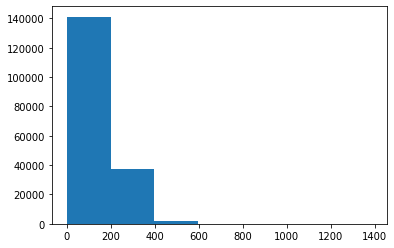

In [60]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lengths, bins=7);

Looks like majority of the sequences are between 0 and 200 characters long.

Find out the 95th percentile of sequence lengths

In [61]:
output_seq_char_length = int(np.percentile(char_lengths,95))
output_seq_char_length

290

Now that we have the optimal output sequence length, we need to find the value of max_tokens, and other parameters

In [62]:
# Get all the keyboard characters for character level embedding
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# Create a character level token vectorizer instance
max_tokens = len(alphabet)

char_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=output_seq_char_length,
                                   standardize='lower_and_strip_punctuation',
                                   name='char_vectorizer')

# Adapt the training data to the char-level vectorizer
char_vectorizer.adapt(train_chars)

After adapting the vectorizer to the char-level vectorizer, let's check some charateristics about it and obtain the vocabulary

In [64]:
char_vocab = char_vectorizer.get_vocabulary()

print(f"Number of unique characters in the vocabulary:\n{len(char_vocab)}\n")
print(f"Least commmon characters:\n{char_vocab[-5:]}\n")
print(f"Most common characters:\n{char_vocab[:5]}\n")

Number of unique characters in the vocabulary:
28

Least commmon characters:
['k', 'x', 'z', 'q', 'j']

Most common characters:
['', '[UNK]', 'e', 't', 'i']



Let's test it on random sentences

In [65]:
random_train_chars = random.choice(train_chars)

print(f"Text that is split at character-level:\n{random_train_chars}\n")
print(f"Length of character sequence:\n{len(random_train_chars.split())}\n")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized character sequence:\n{vectorized_chars}\n")
print(f"Length of vectorized character sequences(after padding):\n{len(vectorized_chars[0])}") # Access the zeroth index because of the double nested list

Text that is split at character-level:
t o   e v a l u a t e   k n o w l e d g e   u p t a k e   f r o m   a   p a r e n t - d i r e c t e d   f a c t s h e e t   a b o u t   m a n a g i n g   p a i n   d u r i n g   i n f a n t   v a c c i n a t i o n s   ,   a n d   t h e   a d d e d   i n f l u e n c e   o f   a   p r e t e s t   .

Length of character sequence:
127

Vectorized character sequence:
[[ 3  7  2 21  5 12 16  5  3  2 23  6  7 20 12  2 10 18  2 16 14  3  5 23
   2 17  8  7 15  5 14  5  8  2  6  3 10  4  8  2 11  3  2 10 17  5 11  3
   9 13  2  2  3  5 22  7 16  3 15  5  6  5 18  4  6 18 14  5  4  6 10 16
   8  4  6 18  4  6 17  5  6  3 21  5 11 11  4  6  5  3  4  7  6  9  5  6
  10  3 13  2  5 10 10  2 10  4  6 17 12 16  2  6 11  2  7 17  5 14  8  2
   3  2  9  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0

Sequences that are shorter than 290 characters in length are <b>padded</b> while those that are longer get truncated, ensuring that all sequences passed into the model are equal in length. 

The `standardize` parameter being set to `lower_and_strip_punctuation` and the split function ensures that punctuation, symbols and whitespaces are removed during the vectorization process

### Create character-level embeddings

In [66]:
char_embed = layers.Embedding(input_dim=max_tokens,
                             output_dim=25,
                             mask_zero=True,
                             name='char_embed')

# Test out the character embedding layer
print(f"Character-level text(before embedding and vectorization):\n{random_train_chars}\n")

random_char_embed = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded Characters (after vectorization and embedding):\n{random_char_embed}\n")
print(f"Character-embedded shape: {random_char_embed.shape}\n")

Character-level text(before embedding and vectorization):
t o   e v a l u a t e   k n o w l e d g e   u p t a k e   f r o m   a   p a r e n t - d i r e c t e d   f a c t s h e e t   a b o u t   m a n a g i n g   p a i n   d u r i n g   i n f a n t   v a c c i n a t i o n s   ,   a n d   t h e   a d d e d   i n f l u e n c e   o f   a   p r e t e s t   .

Embedded Characters (after vectorization and embedding):
[[[-0.03435736 -0.02240083  0.01348933 ...  0.02751119 -0.03335851
    0.03025068]
  [-0.02248063  0.03764668  0.0016242  ... -0.04203231  0.03382835
   -0.01310585]
  [-0.0101815   0.02311272  0.04341078 ... -0.02488264  0.04253242
    0.00575849]
  ...
  [ 0.00456481 -0.01292833  0.00158495 ...  0.03277976  0.04779849
    0.0227989 ]
  [ 0.00456481 -0.01292833  0.00158495 ...  0.03277976  0.04779849
    0.0227989 ]
  [ 0.00456481 -0.01292833  0.00158495 ...  0.03277976  0.04779849
    0.0227989 ]]]

Character-embedded shape: (1, 290, 25)



Basically, for one sentence, there are 290 characters, and each character has 25 dimensions, as stated in the `output_dim` method.

# 🏋️‍♀️ Model Training

In [67]:
# Make Conv1D for characters only

inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_3_conv1d_char_embedding')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# Check the summary of the char_embedding model
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1700      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,089
Trainable params: 10,089
Non-trainable params: 0
_________________________________

### Create Char Dataset

In [68]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [69]:
model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch = int(0.1 * len(train_char_dataset)),
                             epochs=3,
                             validation_data = val_char_dataset,
                             validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 1.2511 - accuracy: 0.4980 - val_loss: 1.0418 - val_accuracy: 0.5871
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0097 - accuracy: 0.5946 - val_loss: 0.9482 - val_accuracy: 0.6227
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9399 - accuracy: 0.6277 - val_loss: 0.8848 - val_accuracy: 0.6529


# ✍🏽 Model Evaluation

In [70]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 1s 2ms/step - loss: 0.8976 - accuracy: 0.6480


[0.8975564241409302, 0.6479875445365906]

In [71]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.18550462, 0.3818396 , 0.06581363, 0.33275086, 0.03409134],
       [0.08573971, 0.7360124 , 0.01054089, 0.09222941, 0.07547753],
       [0.12940826, 0.31110537, 0.22813904, 0.23074937, 0.10059788],
       ...,
       [0.02368325, 0.02797637, 0.16722247, 0.02594096, 0.755177  ],
       [0.04332071, 0.2094358 , 0.22672859, 0.07946207, 0.4410528 ],
       [0.33926517, 0.43119842, 0.14373916, 0.0710407 , 0.01475665]],
      dtype=float32)

In [72]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [73]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_3_preds)

### ⚖️ Metrics

In [74]:
# Results of the models built so far
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,66.483516,0.668206,0.664835,0.618607
custom_token_embedding,78.674037,0.783372,0.786740,0.784180
pretrained token embedding layer,71.408712,0.714759,0.714087,0.711240
Conv1D with character-level embedding,64.798755,0.641725,0.647988,0.636529


---
![title](img/model_4.png) 

The next experiment is a hybrid model that uses both word and character embeddings, as mentioned in the paper.

### 🚂 Build a input pipeline using the tf.data API

In [75]:
# Combine the char and token into one dataset
train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # Both have same labels anyway
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data, train_hybrid_labels))

# Prefetch and batch training data
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat for validation data
val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # Both have same labels anyway
val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_data, val_hybrid_labels))
val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
train_hybrid_dataset, val_hybrid_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

# 🏋️‍♀️ Model Training

In [77]:
# Build the token-level embedding layer (similar to model_1)
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = universal_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

# Build the character-level embedding layer (similar to model_3 with a slight modification to reflect the paper)
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# Combine the two outputs from the models 1 and 2, using layers.Concatenate
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# Final output layers similar to the ones in the paper
x = layers.Dropout(0.5)(token_char_concat)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layers = layers.Dense(num_classes, activation='softmax')(x)

# Construct a model that take character-level and token-level sequences as input, and outputs label probabilities.
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layers,
                        name='model_4_hybrid_token_and_char_embeddings')

model_4.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [78]:
model_4.summary()

Model: "model_4_hybrid_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
___________________________________________________________

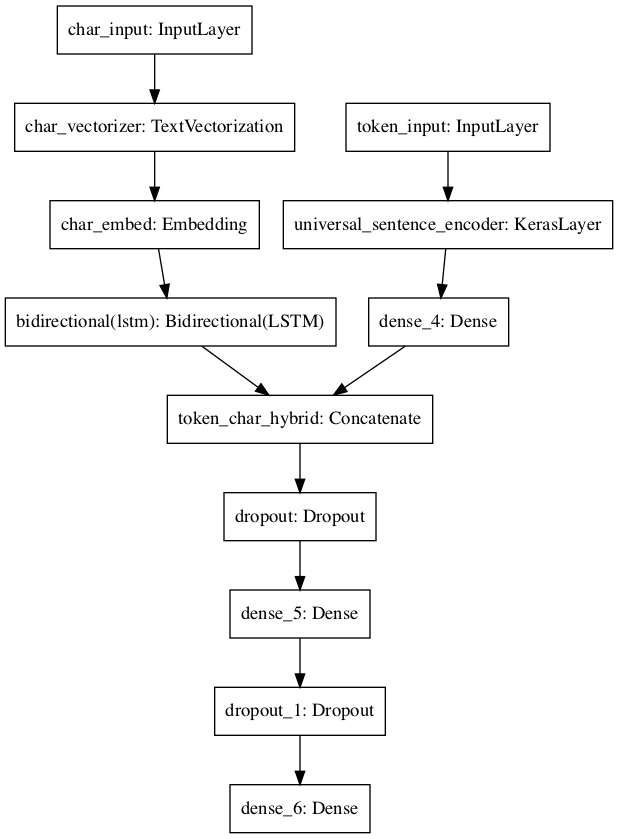

In [79]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [80]:
model_4_history = model_4.fit(train_hybrid_dataset,
                             steps_per_epoch=int(0.1 * len(train_hybrid_dataset)),
                             epochs=3,
                             validation_data=val_hybrid_dataset,
                             validation_steps=int(0.1 * len(val_hybrid_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 121ms/step - loss: 0.9609 - accuracy: 0.6185 - val_loss: 0.7784 - val_accuracy: 0.7038
Epoch 2/3
562/562 [==============================] - 67s 119ms/step - loss: 0.7834 - accuracy: 0.6974 - val_loss: 0.7037 - val_accuracy: 0.7334
Epoch 3/3
562/562 [==============================] - 66s 117ms/step - loss: 0.7596 - accuracy: 0.7089 - val_loss: 0.6814 - val_accuracy: 0.7394


# ✍🏽 Model Evaluation


In [81]:
model_4.evaluate(val_hybrid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6874 - accuracy: 0.7374


[0.6873849630355835, 0.7374222278594971]

In [82]:
model_4_pred_probs = model_4.predict(val_hybrid_dataset)

model_4_pred_probs

array([[4.7474799e-01, 3.0504894e-01, 5.5815321e-03, 2.0916082e-01,
        5.4607182e-03],
       [3.7314793e-01, 4.4514060e-01, 2.5011832e-03, 1.7785162e-01,
        1.3587212e-03],
       [3.0415812e-01, 1.7303492e-01, 6.8108238e-02, 3.9959034e-01,
        5.5108462e-02],
       ...,
       [5.8185495e-04, 1.0076287e-02, 6.7986801e-02, 2.3493780e-04,
        9.2112017e-01],
       [5.9106550e-03, 6.3583829e-02, 2.9170936e-01, 3.0489666e-03,
        6.3574719e-01],
       [1.5735359e-01, 5.2402437e-01, 2.5641102e-01, 1.6265281e-02,
        4.5945819e-02]], dtype=float32)

In [83]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [84]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_4_preds)

In [85]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results,
    "Token & Char Hybrid Embedding w/ Bi-LSTM": model_4_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,66.483516,0.668206,0.664835,0.618607
custom_token_embedding,78.674037,0.783372,0.786740,0.784180
pretrained token embedding layer,71.408712,0.714759,0.714087,0.711240
Conv1D with character-level embedding,64.798755,0.641725,0.647988,0.636529
Token & Char Hybrid Embedding w/ Bi-LSTM,73.742222,0.738185,0.737422,0.735032


---
![title](img/model_5.png) 


# 🛠 Feature Engineering

Before we engineer new features, we need to ensure that these features are _available at test time_, meaning, we should be able to obtain these features from new sets of data.

* Line number: Easily countable
* Total lines: Easily countable as well

### Implementing positional embeddings

> __Positional embeddings__ indicate where a sentence is in a corpus

Since the <b>order</b> in which the sentences appear matter, we can __implement positional embeddings__ which are also available at test time. What i mean is, usually, the classes of the sentences appear in this order {BACKGROUND, OBJECTIVE, METHOD, RESULTS, CONCLUSION}. So, it makes sense to add the line number relative to the number of lines in the abstract.

These values are also available at test time (meaning we can just count the no of lines beforehand, since we dont need to label these). We also can't engineer the labels into the training data because they are not available at test time.

This is called dimensionality reduction.

> One way of creating the positional embedding feature would be to combine the "line number" and `total_lines` feature into `line_position` and see how it performs against having two columns instead

In [86]:
# Our train dataframe already has the data required for creating positional embeddings
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


Since the `line_number` and `total_lines` are already numerical, we can pass them to our model. However, to avoid our model from thinking that `line_number = 5` is five times greater than `line_number = 1`, we will one-hot encode our data using the `tf.one_hot` function

In [87]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

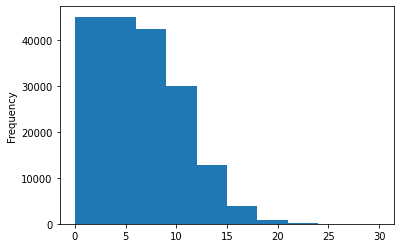

In [88]:
train_df.line_number.plot.hist()

# We can notice that most of the line numbers lie in the 0~20 lines value.

In [89]:
# A scalar defining the depth of the one hot dimension.
line_number_depth = 20

# Use tensorflow to create one-hot-encoded tensors for the line_number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=20)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=20)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=20)


Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

> 🔑 Note: We could create a one-hot tensor which has room for all of the __potential values__ of "line_number" (depth=30), however, this would end up in a tensor of __double__ the size of our current one (depth=15) where the vast majority of values are 0 (sparse). Plus, only ~2,000/180,000 samples have a "line_number" value of over 15. So we __would not be gaining much information about our data for doubling our feature space__. This kind of problem is called the _curse of dimensionality_. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the depth parameter as an extension.

In [90]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [91]:
# Do the same thing, with the total lines
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

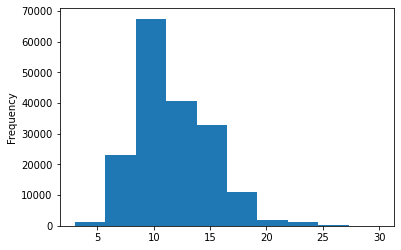

In [92]:
train_df['total_lines'].plot.hist()

In [93]:
np.percentile(train_df.total_lines, 98)

20.0

In [94]:
total_lines_depth = 20

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### 🚂 Build a input pipeline using the tf.data API

In [95]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                  train_total_lines_one_hot,
                                                                  train_sentences,
                                                                  train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# 🏋️‍♀️ Model Training

In [96]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = universal_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

# 2. Char-level embeddings
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_tokens = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_tokens)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(line_number_depth,), dtype=tf.int32, name='line_number_inputs')
# (1, ) means the length of one array is 15, and there can be as many lists as possible

x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                  outputs=x)

# 4. Total lines input
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                 outputs=y)

# 5. Combine the token and char embedding layers into hybrid
combined_embeddings = layers.Concatenate(name='hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with the hybrid embedding
z = layers.Concatenate(name='hybrid_embedding_with_positional_embedding')([line_number_model.output,
                                                                           total_lines_model.output,
                                                                           z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax')(z)

# 8. Put the model together
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                                outputs=output_layer)

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________________________

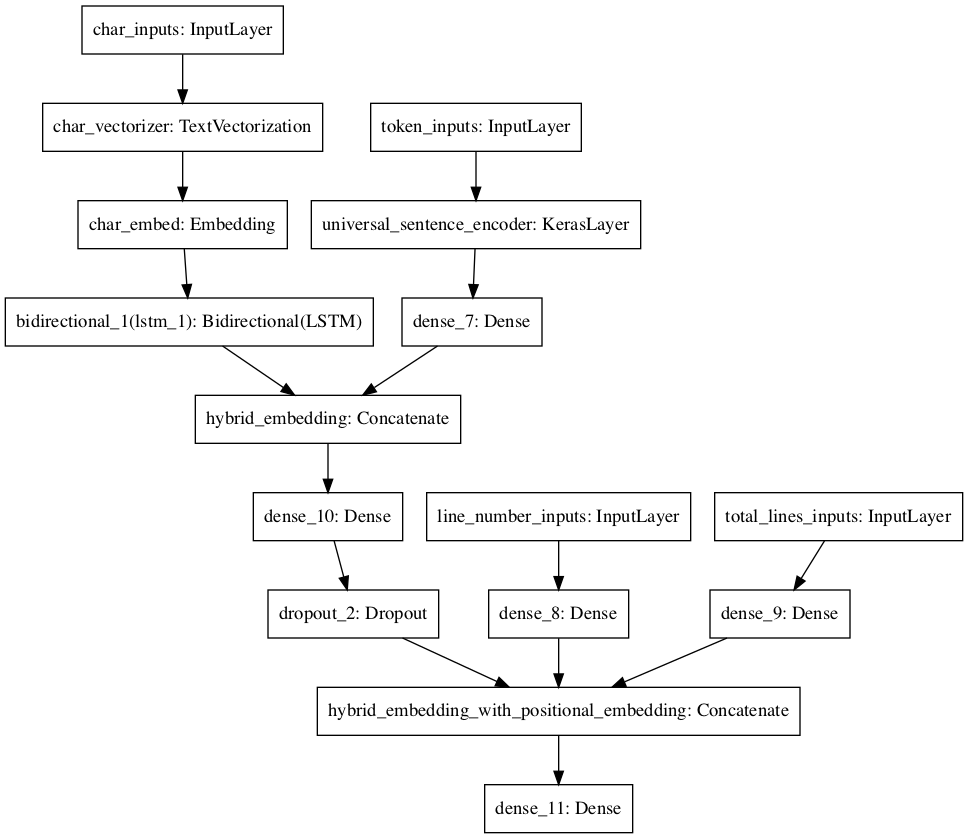

In [97]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [98]:
model_5_history = model_5.fit(train_pos_char_token_dataset,
                             steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                             epochs=3,
                             validation_data=val_pos_char_token_dataset,
                             validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
 18/562 [..............................] - ETA: 1:03 - loss: 1.5631 - accuracy: 0.3576

KeyboardInterrupt: 

# ✍🏽 Model Evaluation


In [ ]:
model_5.evaluate(val_pos_char_token_dataset)

In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_5_preds)

In [ ]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results,
    "Token & Char Hybrid Embedding w/ Bi-LSTM": model_4_results,
    "Token & Char & Positional Embedding w/ Bi-LSTM": model_5_results
})

all_model_results = all_model_results.transpose()
all_model_results

![title](img/conclusion.png) 

### The tribrid model performs the best by a fair margin

Although under performing compared to the model shown in the paper, the model is only trained on 10% of the data.

We can upscale this model to get better scores.


In [ ]:
# Reduce the accuracy to the same scale as others
all_model_results['accuracy'] = all_model_results['accuracy']/100

# Plot and compare the model results on a bar chart
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
# Plot the f1 results alone
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

In [ ]:
model_5.save('skimlit_tribrid_model')

# ✍🏽 Model 5 Evaluation on the Test dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                             test_total_lines_one_hot,
                                                             test_sentences,
                                                             test_chars))

test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))

test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

In [ ]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                 verbose=1)

test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

In [ ]:
test_results = calculate_results(y_true=test_labels_encoded,
                                y_pred=test_preds)
test_results

The model has yet to match the performance of the results in the paper (f1 score of 90, while ours is only 82).

### Model Improvements that can be made
* Train on full dataset
* Fine-tune pretrained embeddings

In [ ]:
# Get a list of the class names of the test predictions
test_pred_classes = [label_encoder.class_[pred] for pred in test_preds]
test_pred_classes